In [1]:
cd ml-100k/

C:\Users\User\RS\MovieLens\ml-100k


In [2]:
import pandas as pd
import numpy as np
import time
import random

import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
pd.set_option('max_row',100000)
pd.set_option('max_column', 2000)

In [3]:
class MySVD():
    def __init__(self, data):
        """
        simple test the performance of SVD in a whole cluster
        :param data:
        """
        self.original_data_df = data

        reader = Reader(rating_scale=(1, 5))
        self.svd_model_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

        self.train_set = self.svd_model_data.build_full_trainset()

        # 80% for training, 20% for testing
        trainset, testset = train_test_split(self.svd_model_data, test_size=0.2)
        # funkSVD
        algo = SVD(biased=False)

        # print(type(testset))
        # train and test
        algo.fit(trainset)

        predictions = algo.test(testset)

        # format (users * items) to generate the whole matrix
        # self.matrix = algo.pu.dot(algo.qi.T)
        # return the RMSE accuracy
        self.RMSE = accuracy.rmse(predictions, verbose=False)
        self.trainset = trainset
        self.testset = testset
        self.algo = algo

class SpecificUserMySVD():
    def __init__(self, data, user_list):
        """
        test the performance in the specific user list from a whole dataset 
        :param data: whole data
        :user_list: a list of user waiting test
        """
        self.original_data_df = data

        reader = Reader(rating_scale=(1, 5))
        self.svd_model_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

        self.train_set = self.svd_model_data.build_full_trainset()

        # 80% for training, 20% for testing
        trainset, testset = train_test_split(self.svd_model_data, test_size=0.2)
        # funkSVD
        algo = SVD(biased=False)

        # print(type(testset))
        # train and test
        algo.fit(trainset)
        
        # print(testset)
        my_test = []
        for i in user_list:
            for k in testset:
                # only get the test set with specific users in the user list
                if i == k[0]:
                    my_test.append(k)
        # print(my_test)

        predictions = algo.test(my_test)

        # format (users * items) to generate the whole matrix
        # self.matrix = algo.pu.dot(algo.qi.T)
        # return the RMSE accuracy
        self.RMSE = accuracy.rmse(predictions, verbose=False)
        self.trainset = trainset
        self.testset = testset
        self.algo = algo




class FilteredDataMySVD():

    def __init__(self, original_second_data_df, new_combined_data_df):
        """
        only test the performance of the second cluster
        :param original_second_data_df:
        :param new_combined_data_df: combined first MFed cluster + second original cluster
        """
        self.original_second_data_df = original_second_data_df
        self.new_combined_data_df = new_combined_data_df

        # after filtering the best one MF matrix, replace the relevant 'MF'ed tuple to original one
        def __testset_filter(second_data_df1, test_data_list):
            new_test_data = []
            for i in second_data_df1.itertuples():
                for k in test_data_list:
                    if i[1] == k[0] and i[2] == k[1]:
                        new_test_data.append((i[1], i[2], i[3]))
            # print(new_test_data)
            return new_test_data

        reader = Reader(rating_scale=(1, 5))
        self.svd_model_data = Dataset.load_from_df(new_combined_data_df[['user_id', 'item_id', 'rating']], reader)

        self.train_set = self.svd_model_data.build_full_trainset()

        # 80% for training, 20% for testing
        trainset, testset = train_test_split(self.svd_model_data, test_size=0.2)

        testset = __testset_filter(original_second_data_df, testset)
        # funkSVD
        algo = SVD(biased=False)
        self.algo = algo
        # print(type(testset))
        # train and test
        algo.fit(trainset)

        predictions = algo.test(testset)

        # format (users * items) to generate the whole matrix
        # self.matrix = algo.pu.dot(algo.qi.T)
        # return the RMSE accuracy
        self.RMSE = accuracy.rmse(predictions, verbose=False)
        self.trainset = trainset
        self.testset = testset


class FilteredAllDataMySVD():

    def __init__(self, original_data_df,  new_combined_MFed_data_df):
        """
        only test real value in two of clusters

        :param original_first_data_df: first original cluster
        :param original_second_data_df: second original cluster
        :param new_combined_data_df: combined first MFed cluster + second original cluster
        """
        self.original_data_df = original_data_df
        self.new_combined_MFed_data_df = new_combined_MFed_data_df

        # after filtering the best one MF matrix, replace the relevant 'MF'ed tuple to original one
        # only test the data with 'true label' instead of what value is 'predicted'
        def __testset_filter(second_data_df1, test_data_list):
            new_test_data = []
            for i in second_data_df1.itertuples():
                for k in test_data_list:
                    if i[1] == k[0] and i[2] == k[1]:
                        new_test_data.append((i[1], i[2], i[3]))
            # print(new_test_data)
            return new_test_data

        reader = Reader(rating_scale=(1, 5))
        self.svd_model_data = Dataset.load_from_df(new_combined_MFed_data_df[['user_id', 'item_id', 'rating']], reader)

        self.train_set = self.svd_model_data.build_full_trainset()

        # 80% for training, 20% for testing
        trainset, testset = train_test_split(self.svd_model_data, test_size=0.2)

        testset = __testset_filter(original_data_df, testset)

        # print(testset)
        # funkSVD

        algo = SVD(biased=False)
        self.algo = algo
        # print(type(testset))
        # train and test
        algo.fit(trainset)

        predictions = algo.test(testset)

        # format (users * items) to generate the whole matrix
        # self.matrix = algo.pu.dot(algo.qi.T)
        # return the RMSE accuracy
        self.RMSE = accuracy.rmse(predictions, verbose=False)
        self.trainset = trainset
        self.testset = testset

In [4]:
def concat_df(df1, df2):
    new_df = pd.concat([df1,df2],axis=0)
    return new_df

def reverse_matrix(algo_model, simple_combined_cluster):
    new_columns = ['user_id', 'item_id', 'rating']
    df_empty = pd.DataFrame(columns=new_columns)
    index = 0

    # generate data from matrix to dataframe
    for i in algo_model.train_set.all_users():
        for k in algo_model.train_set.all_items():

            ruid = algo_model.train_set.to_raw_uid(i)
            riid = algo_model.train_set.to_raw_iid(k)
            est_r = algo_model.algo.my_predict(ruid, riid)

            df_empty.loc[index] = {'user_id': ruid, 'item_id': riid, 'rating': est_r}
            index += 1
    # #Todo
    # test_list = []
    # print(df_empty)
    # fill all the original data back to data input
    for k in simple_combined_cluster.itertuples():

        # consider about test data which is not appear in the algo matrix of train_set;
        # test data should be added back the dataset for next training
        try:
            df_empty.loc[(df_empty[new_columns[0]] == k[1]) & (df_empty[new_columns[1]] == k[2]),new_columns[2]] = k[3]

        except:
            # won't be used, actually.....
            df_empty.loc[index] = {'user_id': k[1], 'item_id': k[2], 'rating': k[3]}
            index+=1
    # # TODO
    # print('final dataframe', df_empty)
    # print('test_list', test_list)
    # print('algo test set', algo_model.testset)
    return df_empty

def specific_users_test(algo, test_list):
    for i in test_list:
        ruid = i[0]
        riid = i[1]
    

def render(x, y1, y2, user_list):

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x,y1)
    ax1.set_ylabel('RMSE')
    ax1.set_title('The number of combination users with time cost')


    ax2.plot(x, y2, 'r')
    ax2.set_ylabel('time cost mins')
    ax1.set_xlabel("combined users "+str(user_list))

    plt.show()

In [5]:
# build environment
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=names)

ratings_without_timestamp = ratings.copy().drop(['timestamp'], axis = 1)

# recorder one user with a vector items
user_items_dict = {}
# recorder the shape of item in each use
user_item_shape_dict ={}


# print(ratings_without_timestamp.loc[ratings_without_timestamp['user_id'] == 0])

for i in range(1, 944):
    user_items_dict[i] = ratings_without_timestamp.loc[ratings_without_timestamp['user_id'] == i]


for k in range(1, 944):
    user_item_shape_dict[k] = len(user_items_dict[k])

ordered_shape = sorted(user_item_shape_dict.items(), key=lambda x: x[1], reverse=True)

# print(ordered_shape)
# save the number of users in set
users_set = set()
[users_set.add(i) for i in range(1, 944)]

first_user_key = ordered_shape[random.randint(0,942)][0]
users_set.remove(first_user_key)
# print(first_user_key)

# first part of big cluster which is used to combine other cluster
first_part_df = user_items_dict[first_user_key]

# contain a few users that can arrive the best results
users_combination = []
users_combination.append(first_user_key)
# recorder the original combined users-items clusters
cur_combined_orginal_df = first_part_df


# variable for render
# recoder the list of results of RMSE
global_RMSE = []
# recorder the list of time cost
time_cost = []
# recorder the model of the best RMSE

# for further process
global_model = 0
# MFed data + added data ==> fill with real value already
global_MF_df = 0
global_result = float("inf")
global_user_list = []

use [706] to combine 384 : 0.5666388139322487


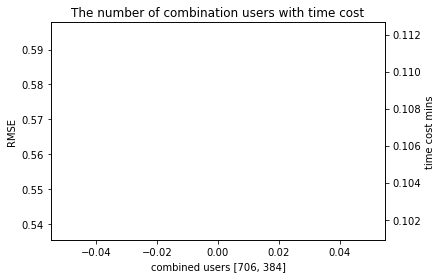

use [706, 384] to combine 804 : 1.0634836218502426


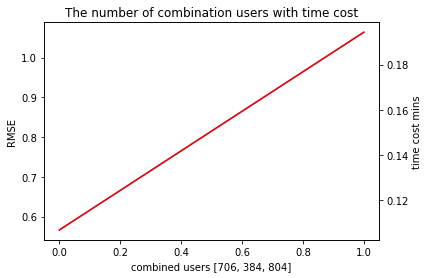

use [706, 384, 804] to combine 655 : 1.436589833881261


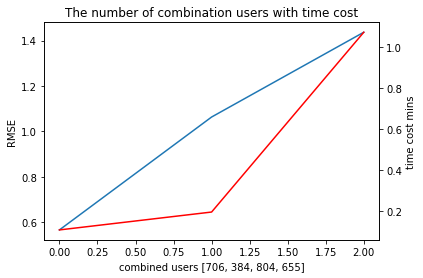

use [706, 384, 804, 655] to combine 537 : 1.2916811171219735


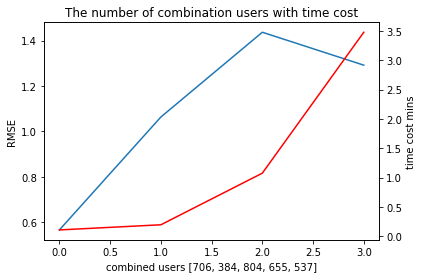

use [706, 384, 804, 655, 537] to combine 429 : 1.1478078945376256


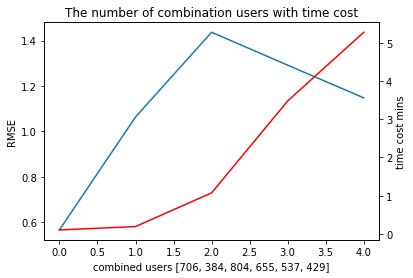

use [706, 384, 804, 655, 537, 429] to combine 10 : 0.964701928730972


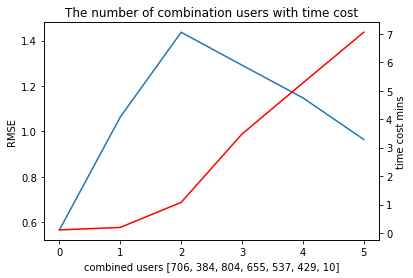

use [706, 384, 804, 655, 537, 429, 10] to combine 378 : 0.8455803945657568


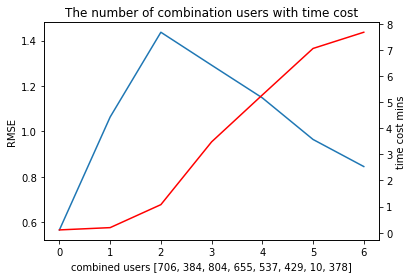

use [706, 384, 804, 655, 537, 429, 10, 378] to combine 345 : 0.8072795770265162


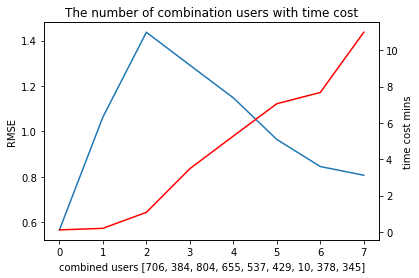

In [6]:
# How many iteration
n = 0
while n<100:
    # recorder original dataframe in the for loop
    temp_original_data = 0
    start =time.time()
    # recorder the minimal RMSE
    min_value = float("inf")
    # recorder which user can arrive the lower RMSE
    cur_user_key = -1
    # recorder current algo model
    algo_model = 0

    for i in users_set:
        added_data = user_items_dict[i]

        # simple combined the first part(with MFed) + added data
        new_combined_data = concat_df(first_part_df, added_data)
        # temp combined original data for current data selection
        temp_combined_original_df=concat_df(cur_combined_orginal_df, added_data)

        # if test data never have a interaction with item (with empty test set)
        try:
            # return model which test the whole data with original ratings in the test set
            temp_algo_model = FilteredAllDataMySVD(temp_combined_original_df,new_combined_data)
            temp_result = temp_algo_model.RMSE

        except:
            continue

        # recorder the min RMSE with relevant key, model and combinined original data
        if temp_result < min_value:
            cur_user_key = i
            min_value = temp_result
            algo_model = temp_algo_model
            # the best temp original data in each for loop iteration
            temp_original_data = temp_combined_original_df

    # the best combined original df in each while loop iteration
    cur_combined_orginal_df = temp_original_data
    # reverse the matrix and fill back real value to predict value
    # return a MFed whole dataset, but real label is reversed to original rating
    first_part_df = reverse_matrix(algo_model, cur_combined_orginal_df)

    print('use', [i for i in users_combination], 'to combine', cur_user_key, ':', min_value)

    # clean relevant user key in the set
    users_set.remove(cur_user_key)
    users_combination.append(cur_user_key)

    global_RMSE.append(min_value)
    x = list(range(0, len(global_RMSE)))
    n += 1
    end = time.time()
    
    time_cost.append((end-start)/60)

    if global_result > min_value:
        global_result = min_value
        global_model = algo_model
        global_MF_df = first_part_df
        global_user_list = users_combination

    render(x, global_RMSE, time_cost, users_combination)
    
    if min_value < 0.78 and len(users_combination)>3:
        break

In [7]:
# global_result = min_value
#         global_model = algo_model
#         global_MF_df = first_part_df
#         global_user_list = users_combination

In [8]:
# test the performance of specific cluster in the whole data with MF
# user_cluster = [405, 726, 129, 163, 369, 161, 181, 61, 552, 55, 182, 418, 353, 772]
iteration = 10
# 1.0 test performance in the whole dataset # results between 1.07~1.58
spe_user_result = 0
for i in range(iteration):
    spe_user_result += SpecificUserMySVD(ratings_without_timestamp, global_user_list).RMSE
print('the results of specific users', spe_user_result/iteration)

# 2.0 test performance in specific user set
df_new_empty = pd.DataFrame(columns = ['user_id', 'item_id', 'rating'])
for i in global_user_list:
    df_new_empty = concat_df(df_new_empty, user_items_dict[i])
# results of simple combined to generate the best situation
# print(df_new_empty)
# print(MySVD(df_new_empty).RMSE)  # results between 1.47~1.76

sim_combined_result= 0
# simple combined user group with mySVD
for i in range(iteration):
    sim_combined_result += MySVD(df_new_empty).RMSE
print('the results of simple combined users', sim_combined_result/iteration)

the results of specific users 0.7647574677133867
1.1223221466609863
the results of simple combined users 1.1477254536822756
